In [17]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [8]:
spectrograms_dir = "audio_representations/spectrograms"

images = []
labels = []

for file_name in os.listdir(spectrograms_dir):
    if file_name.endswith(".png"):
        file_path = os.path.join(spectrograms_dir, file_name)
        
        # Convert to numpy
        img = Image.open(file_path).convert("RGB")
        img = img.resize((256, 256))
        img_array = np.array(img)
        
        images.append(img_array)
        
        label = int(file_name.split("-")[2]) - 1
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

# Normalize
images = images / 255.0

# One hot
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes=num_classes)

X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Ensemble d'entraînement : {X_train.shape}, {y_train.shape}")
print(f"Ensemble de validation : {X_val.shape}, {y_val.shape}")
print(f"Ensemble de test : {X_test.shape}, {y_test.shape}")



Ensemble d'entraînement : (1008, 256, 256, 3), (1008, 8)
Ensemble de validation : (216, 256, 256, 3), (216, 8)
Ensemble de test : (216, 256, 256, 3), (216, 8)


In [11]:

def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Avoid overfitting
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

input_shape = (256, 256, 3)  # 3 channels (RGB)
model = create_cnn_model(input_shape, num_classes)

model.summary()

c:\Users\aubin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,840,008 (56.61 MB)

 Trainable params: 14,840,008 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Loss on the test set : {test_loss}")
print(f"Accuracy on the test set : {test_accuracy}")

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2110 - loss: 2.0318 - val_accuracy: 0.3009 - val_loss: 1.8616
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 989ms/step - accuracy: 0.2926 - loss: 1.8045 - val_accuracy: 0.4028 - val_loss: 1.6770
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 984ms/step - accuracy: 0.3978 - loss: 1.6241 - val_accuracy: 0.4167 - val_loss: 1.5317
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 970ms/step - accuracy: 0.4760 - loss: 1.3928 - val_accuracy: 0.4861 - val_loss: 1.4105
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 937ms/step - accuracy: 0.5893 - loss: 1.1838 - val_accuracy: 0.5185 - val_loss: 1.3879
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 925ms/step - accuracy: 0.6285 - loss: 1.0371 - val_accuracy: 0.5000 - val_loss: 1.4365
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 955ms/step - accuracy: 0.7152 - loss: 0.7683 - val_accuracy: 0.5648 - val_loss: 1.3833
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 902ms/step - accuracy: 0.7636 - loss: 0.6696 - val_accurac

In [14]:
model.save("weights/ser_cnn_spectrograms.h5")


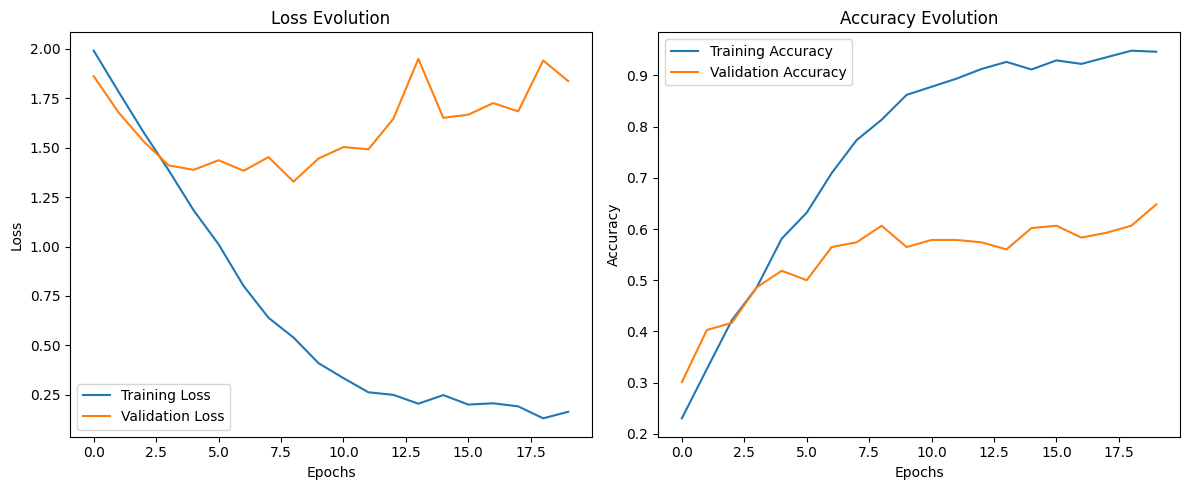

In [16]:
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Evolution")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()



7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step


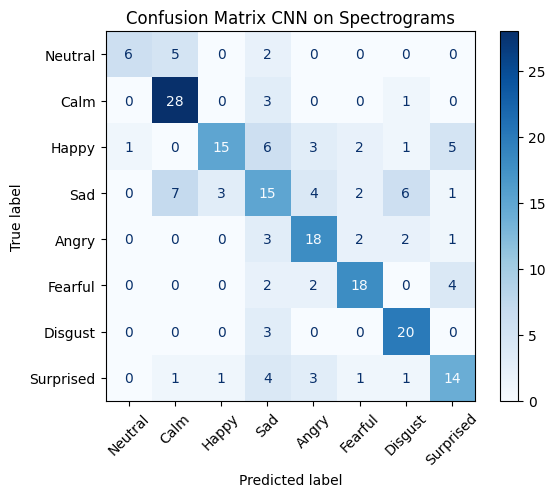

In [20]:
emotion_labels = [
    "Neutral", "Calm", "Happy", "Sad", "Angry", 
    "Fearful", "Disgust", "Surprised"
]

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  
y_true_labels = np.argmax(y_test, axis=1) 

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=emotion_labels
)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  
plt.title("Confusion Matrix CNN on Spectrograms")
plt.show()
